**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [42]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [43]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [44]:
def split_vals(a,n): 
    return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [8]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [45]:
set_rf_samples(50000)

In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2064722087998546, 0.24957425091394667, 0.9109040354827597, 0.8887634459617343, 0.8937981043545038]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [14]:
preds =  np.stack([t.predict(X_valid) for t in m.estimators_])

In [19]:
preds.shape

(40, 12000)

Detailed explanation : Lesson 2 , 1:05

We'll grab the prediction for each individual tree. and look at one example.

```
[t.predict(X_valid) for t in m.estimators_]

[array([8.97828, 9.07949, 8.9872 , ..., 9.15346, 9.13063, 9.13063]),
 array([9.0676 , 9.05311, 9.15905, ..., 9.36715, 9.51524, 9.51524]),
 array([9.72667, 9.11145, 9.12741, ..., 9.13132, 9.13132, 9.13132]),
 array([9.43192, 9.03787, 8.94893, ..., 9.69288, 9.03422, 9.03422]),
 .
 .
 array([9.56517, 9.7535 , 9.28813, ..., 9.35789, 9.35789, 9.35789])]

np.stack([t.predict(X_valid) for t in m.estimators_])

array([[8.97828, 9.07949, 8.9872 , ..., 9.15346, 9.13063, 9.13063],
       [9.0676 , 9.05311, 9.15905, ..., 9.36715, 9.51524, 9.51524],
       [9.72667, 9.11145, 9.12741, ..., 9.13132, 9.13132, 9.13132],
       ...,
       [9.59085, 9.42477, 8.99257, ..., 9.94534, 9.31309, 9.31309],
       [9.44767, 9.24552, 9.02992, ..., 9.37498, 9.17196, 9.17196],
       [9.56517, 9.7535 , 9.28813, ..., 9.35789, 9.35789, 9.35789]])
       ```

In [21]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
print(preds[:,0], y_valid[0])
print(np.mean(preds[:,0]), np.std(preds[:,0]))

CPU times: user 1.4 s, sys: 12 ms, total: 1.42 s
Wall time: 1.42 s
[8.97828 9.0676  9.72667 9.43192 9.34583 9.15812 9.26801 9.12599 8.94847 9.04713 9.19432 9.20951 8.95361
 9.15328 9.60892 9.05725 9.09463 9.18304 9.44394 9.09903 9.33529 9.00741 9.17774 9.01522 9.31057 9.09308
 9.18435 9.62888 9.04113 9.20971 9.87497 9.63083 9.00849 9.54564 9.53393 9.01968 9.02646 9.59085 9.44767
 9.56517] 9.104979856318357
9.258565330569022 0.24260384058762


When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [22]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 100 ms, sys: 64 ms, total: 164 ms
Wall time: 482 ms


(9.258565330569022, 0.24260384058762)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

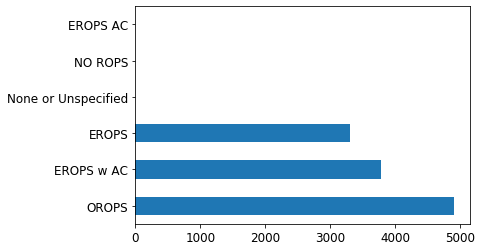

In [23]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [24]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.840005,0.276957
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.578379,0.262956
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.686073,0.225259


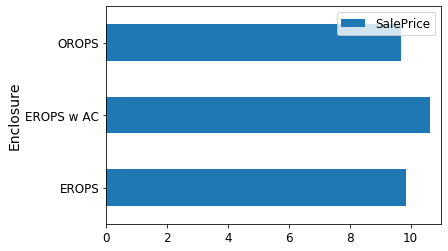

In [25]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

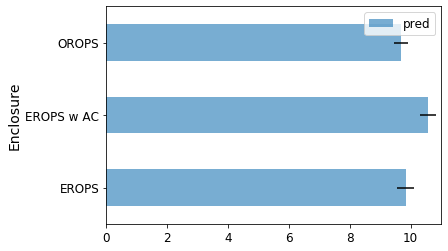

In [26]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

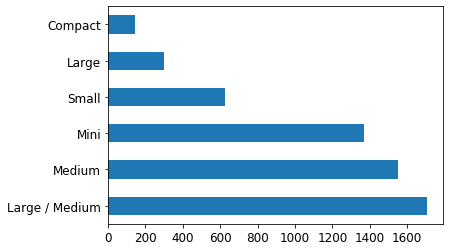

In [27]:
raw_valid.ProductSize.value_counts().plot.barh();

In [28]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.848262,0.340000
Large,10.470589,10.393206,0.359604
Large / Medium,10.691871,10.651378,0.292022
Medium,10.681511,10.628515,0.283781
Mini,9.535147,9.558051,0.260019
Small,10.324448,10.319008,0.305365


In [29]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034600
Compact           0.034524
Small             0.029592
Large / Medium    0.027416
Mini              0.027204
Medium            0.026700
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [47]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.169244
37,Coupler_System,0.114286
13,ProductSize,0.099143
14,fiProductClassDesc,0.071500
2,ModelID,0.051786
63,saleElapsed,0.050703
19,Enclosure,0.049041
10,fiSecondaryDesc,0.044934
38,Grouser_Tracks,0.036665
39,Hydraulics_Flow,0.035910


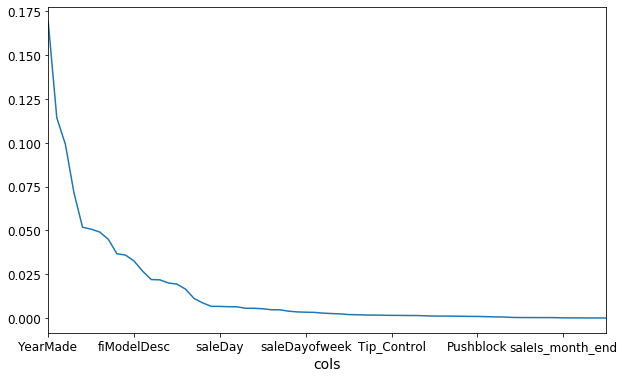

In [48]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [49]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

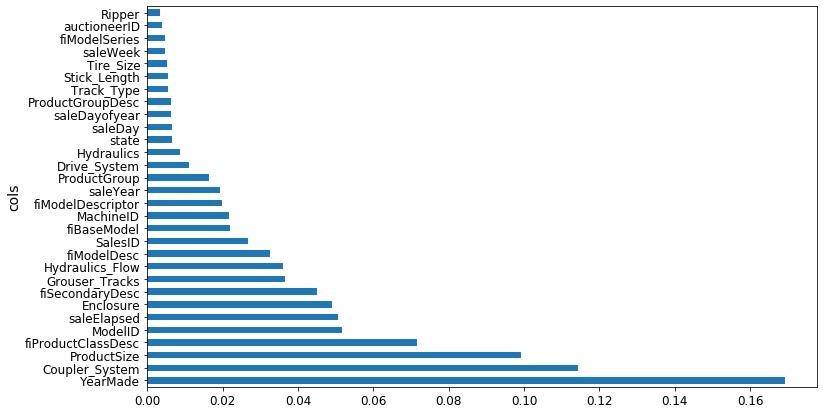

In [50]:
plot_fi(fi[:30]);

In [51]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

26

In [52]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [53]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2070004490454998, 0.2453595564380467, 0.9104475645705797, 0.8924887454442697, 0.8940254518138825]


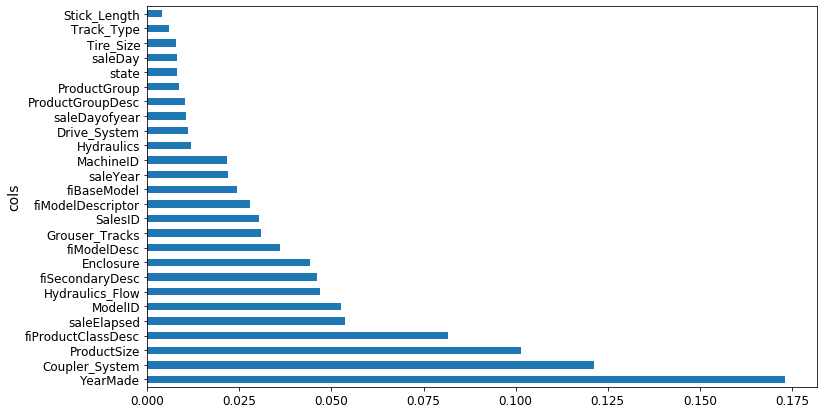

In [54]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [55]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2078085075204673, 0.2537948935776615, 0.9097470361800948, 0.8849693077318515, 0.8919639988980134]


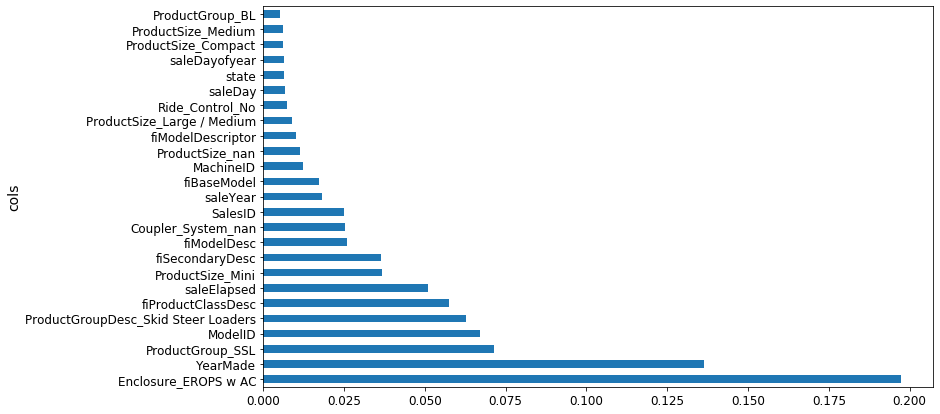

In [56]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [57]:
from scipy.cluster import hierarchy as hc

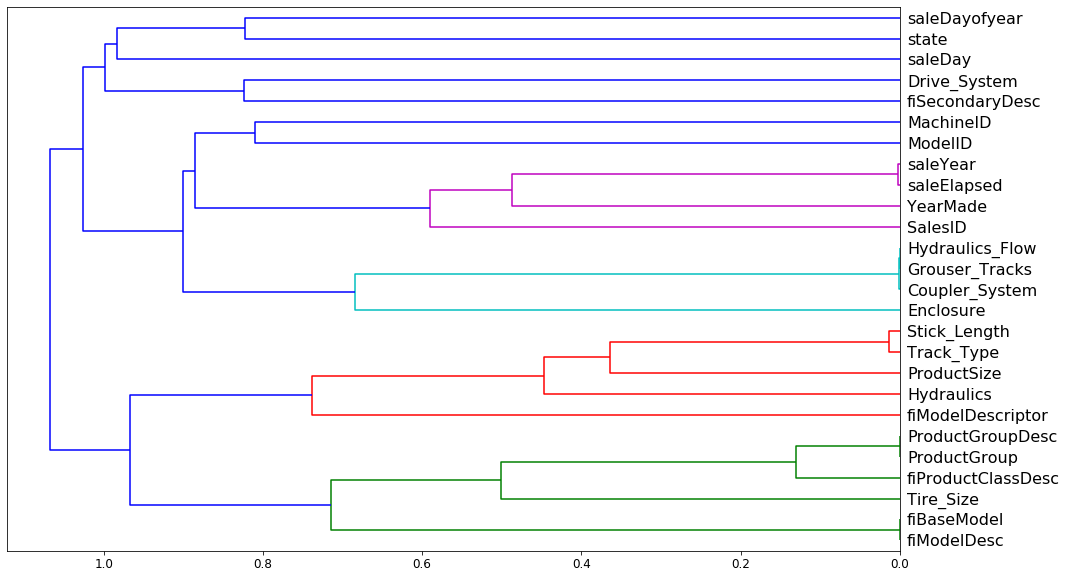

In [58]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [59]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [60]:
get_oob(df_keep)

0.8903006131993605

Now we try removing each variable one at a time.

In [61]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8901749913424277
saleElapsed 0.8873318930573476
fiModelDesc 0.8877927092733384
fiBaseModel 0.8893895456606841
Grouser_Tracks 0.8903959153469776
Coupler_System 0.889984482287425


It looks like we can try one from each group for removal. Let's see what that does.

In [62]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8882664727462349

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [63]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [64]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [66]:
# keep_cols = np.load('tmp/keep_cols.npy')
# df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [67]:
reset_rf_samples()

In [68]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12560909579593305, 0.2261627197489027, 0.967025592191029, 0.9086538999249834, 0.908550912369287]


# Partial dependence

In [71]:
from pdpbox import pdp
from plotnine import *

In [73]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [74]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

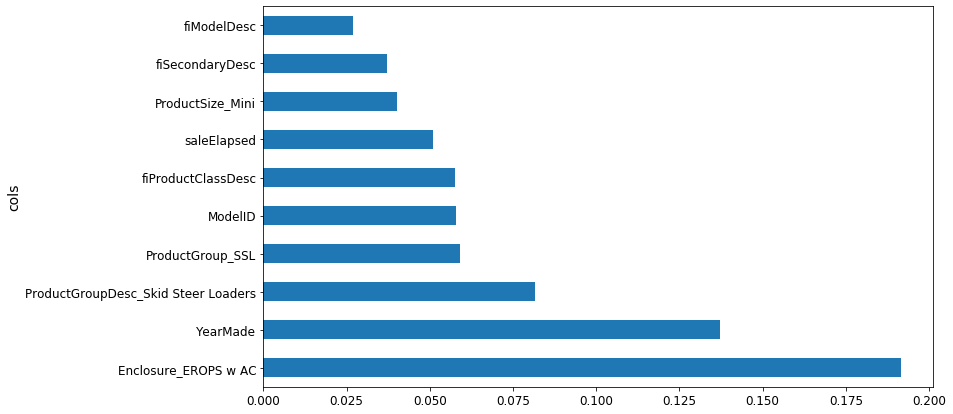

In [75]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

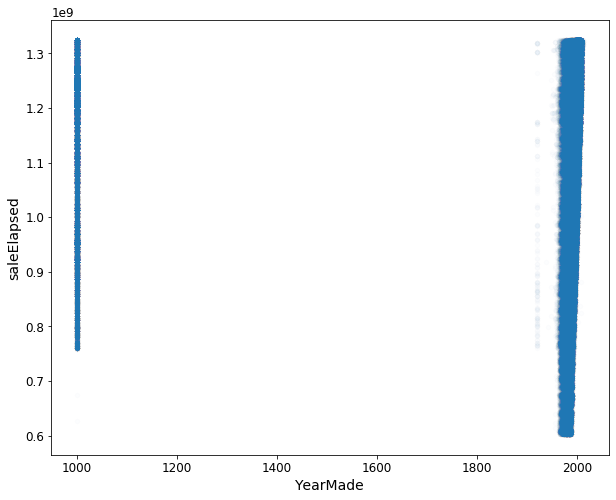

In [76]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [77]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

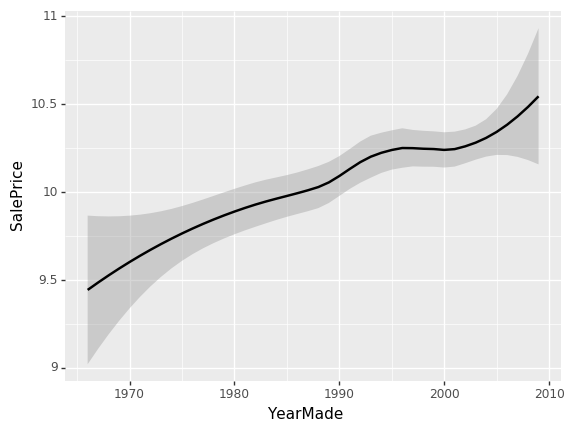

<ggplot: (8770640093701)>

In [79]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [80]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [88]:
# def plot_pdp(feat, clusters=None, feat_name=None):
#     feat_name = feat_name or feat
#     p = pdp.pdp_isolate(m, x, feat)
#     return pdp.pdp_plot(p, feat_name, plot_lines=True,
#                         cluster=clusters is not None,
#                         n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa12db21fd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa12db7fa10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


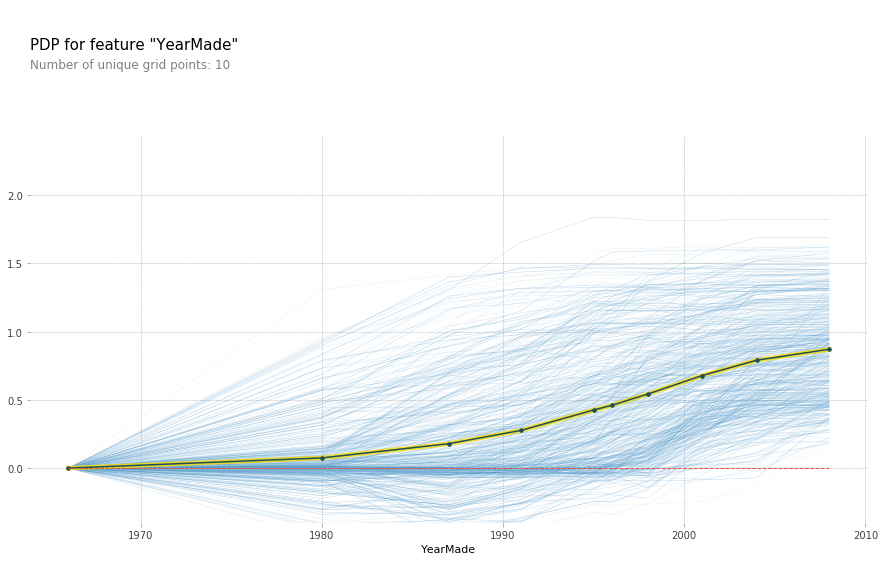

In [89]:
def plot_pdp(feat_name, clusters=None):
#feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

plot_pdp(feat_name='YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa0bcd93250>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fa0bcd27990>})

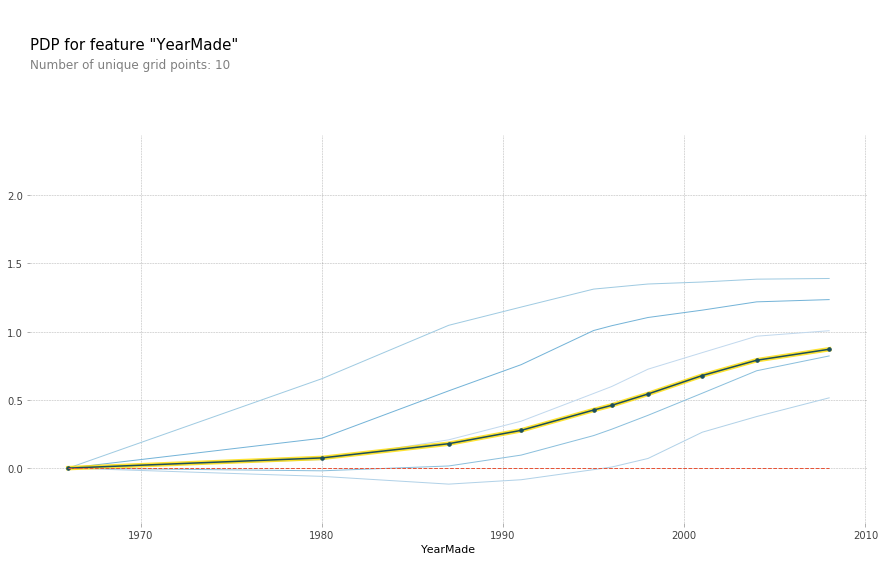

In [90]:
#plot_pdp('YearMade', clusters=5)
plot_pdp('YearMade', clusters=5)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

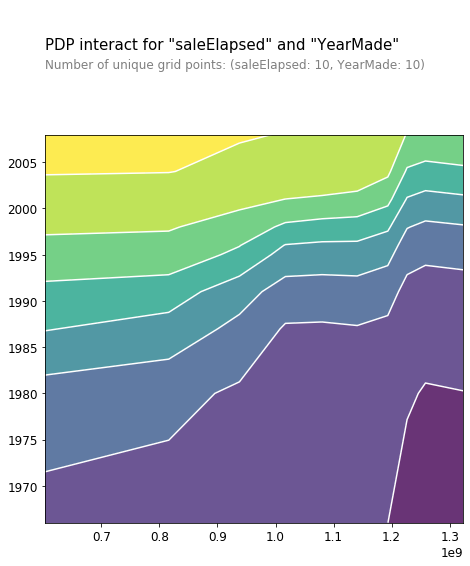

In [96]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

In [97]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

TypeError: plot_pdp() takes from 1 to 2 positional arguments but 3 were given

In [98]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

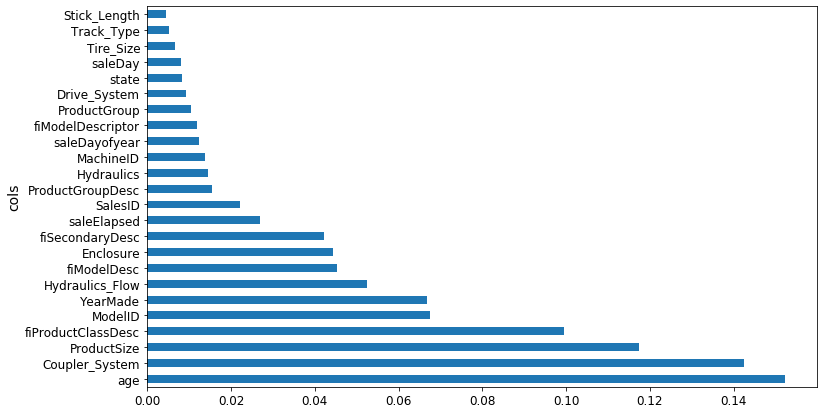

In [99]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [102]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [103]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          1,          0,
                 0,       3232,    4364751,    2300944,          0,          4,          0,         12,
                35,         16,        259,          4,          2,         29,          0,         11]])

In [104]:
prediction, bias, contributions = ti.predict(m, row)

In [105]:
prediction[0], bias[0]

(array([9.29387]), 10.10474328852106)

In [108]:
contributions

array([[ 0.08426,  0.06592, -0.5327 , -0.19246,  0.06962, -0.0053 , -0.05275, -0.05818,  0.02639, -0.06795,
         0.00096,  0.01666, -0.02896,  0.00166,  0.00329, -0.00585, -0.00183, -0.01146, -0.00761,  0.02518,
         0.01194, -0.01226, -0.00878, -0.13065]])

In [106]:
idxs = np.argsort(contributions[0])

In [107]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.532703001897301),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.19245888234387434),
 ('age', 11, -0.13065442637665656),
 ('fiModelDesc', 'KX1212', -0.06794647850584426),
 ('fiSecondaryDesc', nan, -0.0581807426606054),
 ('Enclosure', 'EROPS', -0.052752317109081216),
 ('fiModelDescriptor', nan, -0.02896180816424341),
 ('Stick_Length', 'None or Unspecified', -0.012258980443337864),
 ('saleDay', 16, -0.01146421746744557),
 ('Tire_Size', nan, -0.008776113247195471),
 ('saleDayofyear', 259, -0.0076123530558540155),
 ('Hydraulics', 'Standard', -0.005850313844188326),
 ('saleElapsed', 1284595200, -0.005300526584282617),
 ('state', 'Ohio', -0.0018342898237651006),
 ('SalesID', 4364751, 0.0009602888545159783),
 ('ProductGroup', 'TEX', 0.001664145212059731),
 ('Drive_System', nan, 0.003292716077059943),
 ('Track_Type', 'Steel', 0.011943218042459191),
 ('MachineID', 2300944, 0.016662719427578042),
 ('ProductGroupDesc', 'Track Exca

In [ ]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [ ]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


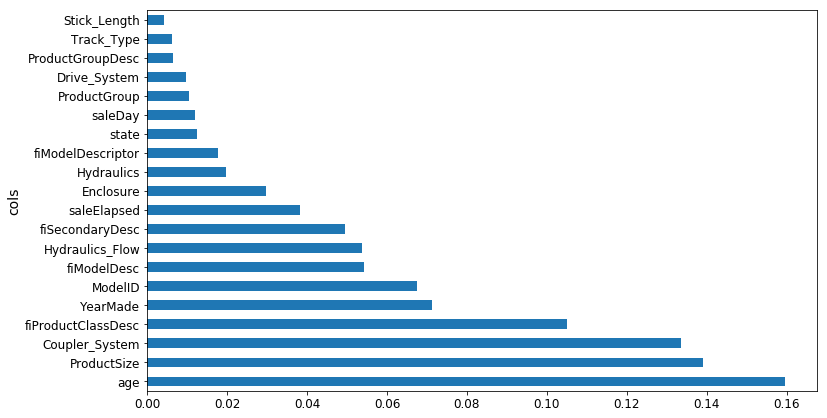

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
